In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split
import numpy as np
import time
import speechbrain as sb
from speechbrain.nnet import RNN
import torchkeras
import torchmetrics
from sklearn.model_selection import train_test_split
from torchkeras.kerascallbacks import TensorBoardCallback
from tensorboard import notebook
torch.set_default_dtype(torch.double)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
x = np.load('data/features_new.npy')
y = np.load('data/label_new.npy')

y_max = 1595.88
y_min = 1508.19
normalized_y = (y - y_min) / (y_max - y_min)

# x = x.reshape((-1, 512, 1))

In [3]:
small_x = np.zeros((16502, 512))
small_y = np.zeros((16502, 2))
for i in range(len(x)):
    if i % 10 == 0:
        small_num = int(i / 10)
        small_x[small_num] = x[i]
        small_y[small_num] = normalized_y[i]

In [4]:
small_x = small_x.reshape((-1, 1, 512))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(small_x, small_y, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(13201, 1, 512)
(3301, 1, 512)
(13201, 2)
(3301, 2)


In [6]:
ds_train = TensorDataset(torch.tensor(x_train),torch.tensor(y_train))
ds_test = TensorDataset(torch.tensor(x_test),torch.tensor(y_test))

In [7]:
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=128, shuffle=True)

In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_shape,
                 hidden_size, num_layers,
                 output_size, dropout):
        super(GRUModel, self).__init__()
        self.cnn1 = nn.Conv1d(1, 64, 5)
        self.pool1= nn.MaxPool1d(2, 2)
        self.cnn2 = nn.Conv1d(64, 64, 5)
        self.pool2= nn.MaxPool1d(2, 2)
        self.cnn3 = nn.Conv1d(64, 64, 5)
        self.pool3= nn.MaxPool1d(2, 2)
        self.gru = RNN.LiGRU(input_shape=input_shape,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             dropout=dropout)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(512, output_size)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.pool1(out)
        out = self.cnn2(out)
        out = self.pool2(out)
        out = self.cnn3(out)
        out = self.pool3(out)
        # print("Conv output shape:", out.shape)
        out = out.permute(0, 2, 1)
        # print("Conv output shape:", out.shape)
        out, _ = self.gru(out)
        out = out[:, -1, :]
        out = self.flatten(out)
        out = self.linear(out)
        return out


In [9]:
net = nn.Sequential(
    GRUModel(input_shape=(128, 60, 64), hidden_size=512, num_layers=4, output_size=2, dropout=0.2)
)

compiled_model = torch.jit.script(net)

In [10]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, pred, target):
        mse = nn.MSELoss()
        loss = torch.sqrt(mse(pred, target))
        return loss
    
criterion = RMSELoss()

<<<<<< ⚡️ cuda is used >>>>>>


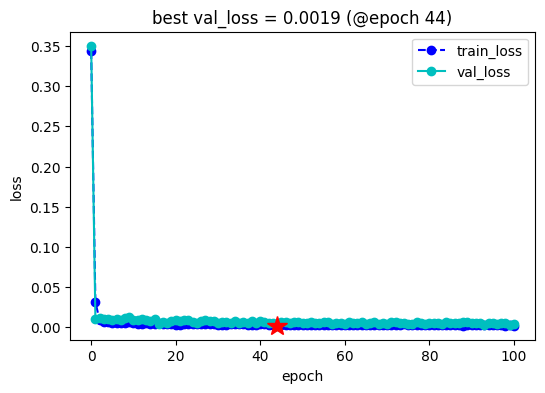

In [11]:
model = torchkeras.KerasModel(compiled_model,
                              loss_fn = criterion,
                              optimizer= torch.optim.Adam(compiled_model.parameters(),lr = 1e-4)
                             )

model.load_ckpt('per_train/checkpoint.pt')

dfhistory=model.fit(train_data=dl_train,
                    val_data=dl_test,
                    epochs=100,
                    patience=100,
                    ckpt_path='new.pt',
                    monitor="val_loss",
                    mode="min",
                    plot=True, 
                    callbacks = [TensorBoardCallback(save_dir='runs',
                                model_name='cnn_ligru',log_weight=True,log_weight_freq=5)]
                   )

In [14]:
notebook.list() 
notebook.start("--logdir ./runs")

Known TensorBoard instances:
  - port 6007: logdir /root/tf-logs (started 5 days, 0:18:28 ago; pid 953)
  - port 6007: logdir /root/tf-logs (started 4 days, 4:31:37 ago; pid 694)
  - port 6007: logdir /root/tf-logs (started 1 day, 4:29:07 ago; pid 697)
  - port 6007: logdir /root/tf-logs (started 4:50:07 ago; pid 692)
  - port 6006: logdir ./runs (started 2:02:27 ago; pid 6475)


Reusing TensorBoard on port 6006 (pid 6475), started 2:02:27 ago. (Use '!kill 6475' to kill it.)